In [17]:
# ==========================================================
# 🧩 Step 1: Install Required Libraries
# ==========================================================
!pip install optuna lightgbm --quiet

# ==========================================================
# 🧩 Step 2: Import Libraries
# ==========================================================
import pandas as pd
import numpy as np
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lightgbm import early_stopping

# ==========================================================
# 🧩 Step 3: Load Dataset (uploaded in Colab)
# ==========================================================
file_path = "k2pandc_2025.10.04_02.08.07.csv"
print(f"📂 Loading dataset: {file_path}")

df = pd.read_csv(file_path, comment="#")
print("✅ Loaded successfully!")
print("Shape:", df.shape)
print("Columns (first 20):", df.columns[:20].tolist())

# ==========================================================
# 🧩 Step 4: Target Column Setup
# ==========================================================
# Use 'disposition' (since this is your dataset 2)
target_col = "disposition"

if target_col not in df.columns:
    raise ValueError(f"❌ Target column '{target_col}' not found in {file_path}")

print(f"🎯 Using target column: {target_col}")

# ==========================================================
# 🧩 Step 5: Prepare Data
# ==========================================================
# Select only numeric columns
X = df.select_dtypes(include=np.number)
y = df[target_col]

# Fill missing numeric values
X = X.fillna(0)

# Remove rows with missing targets
y = y.dropna()
X = X.loc[y.index]

# Encode target labels if they are strings
if y.dtype == "object":
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y = le.fit_transform(y)
    print("🔤 Encoded target labels:", list(le.classes_))

# Split data into train/test
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Data prepared for training!")
print("Training shape:", X_train.shape, "Validation shape:", X_val.shape)

# ==========================================================
# 🧩 Step 6: Define Optuna Objective Function
# ==========================================================
def objective(trial):
    params = {
        "objective": "multiclass",
        "num_class": len(np.unique(y)),
        "n_estimators": 500,
        "random_state": 42,
        "n_jobs": -1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 256),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 300),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-4, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-4, 10.0, log=True),
    }

    model = lgb.LGBMClassifier(**params)

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="multi_logloss",
        callbacks=[early_stopping(50, verbose=False)],
    )

    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    return acc

# ==========================================================
# 🧩 Step 7: Run Optuna Optimization
# ==========================================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("\n" + "="*60)
print("🚀 OPTUNA OPTIMIZATION COMPLETE 🚀")
print("="*60)
print(f"✅ Best Accuracy: {study.best_value:.4f}")
print("📈 Best Hyperparameters:")
for key, value in study.best_params.items():
    print(f"  - {key}: {value}")

# ==========================================================
# 🧩 Step 8: Train Final Model with Best Params
# ==========================================================
best_params = study.best_params
best_params.update({
    "objective": "multiclass",
    "num_class": len(np.unique(y)),
    "n_estimators": 500,
    "random_state": 42,
})

final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="multi_logloss",
    callbacks=[early_stopping(50, verbose=False)],
)

# ==========================================================
# 🧩 Step 9: Evaluate Model
# ==========================================================
y_pred = final_model.predict(X_val)

print("\n🎯 Final Model Evaluation")
print("="*40)
print("✅ Accuracy:", accuracy_score(y_val, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_val, y_pred))
print("\n🧩 Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


[I 2025-10-05 05:06:09,266] A new study created in memory with name: no-name-91f0cefc-c836-4618-b66f-a762c8ec4d29


📂 Loading dataset: k2pandc_2025.10.04_02.08.07.csv
✅ Loaded successfully!
Shape: (4004, 94)
Columns (first 20): ['pl_name', 'hostname', 'default_flag', 'disposition', 'disp_refname', 'sy_snum', 'sy_pnum', 'discoverymethod', 'disc_year', 'disc_facility', 'soltype', 'pl_controv_flag', 'pl_refname', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']
🎯 Using target column: disposition
🔤 Encoded target labels: ['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE', 'REFUTED']
✅ Data prepared for training!
Training shape: (3203, 76) Validation shape: (801, 76)
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8617407112351056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8617407112351056
[LightGBM] [Warning] lambda_l2 is set=0.0017200089668002185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001720

[I 2025-10-05 05:06:12,904] Trial 0 finished with value: 0.9800249687890137 and parameters: {'learning_rate': 0.015971520456930142, 'num_leaves': 106, 'max_depth': 6, 'min_child_samples': 160, 'feature_fraction': 0.8617407112351056, 'bagging_fraction': 0.8831533919310657, 'bagging_freq': 2, 'lambda_l1': 0.004809092494017566, 'lambda_l2': 0.0017200089668002185}. Best is trial 0 with value: 0.9800249687890137.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8617407112351056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8617407112351056
[LightGBM] [Warning] lambda_l2 is set=0.0017200089668002185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017200089668002185
[LightGBM] [Warning] lambda_l1 is set=0.004809092494017566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004809092494017566
[LightGBM] [Warning] bagging_fraction is set=0.8831533919310657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8831533919310657
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5942523041368766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5942523041368766
[LightGBM] [Warning] lambda_l2 is set=4.366482352961

[I 2025-10-05 05:06:14,898] Trial 1 finished with value: 0.9712858926342073 and parameters: {'learning_rate': 0.013843130891503257, 'num_leaves': 41, 'max_depth': 9, 'min_child_samples': 154, 'feature_fraction': 0.5942523041368766, 'bagging_fraction': 0.5645870877323653, 'bagging_freq': 5, 'lambda_l1': 0.00020370715803264393, 'lambda_l2': 4.3664823529614205}. Best is trial 0 with value: 0.9800249687890137.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5700759284022965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5700759284022965
[LightGBM] [Warning] lambda_l2 is set=0.002011425558450713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002011425558450713
[LightGBM] [Warning] lambda_l1 is set=0.0011327766546448592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011327766546448592
[LightGBM] [Warning] bagging_fraction is set=0.5811064911669548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5811064911669548
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5700759284022965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5700759284022965
[LightGBM] [Warning] lambda_l2 is set=0.002011425558

[I 2025-10-05 05:06:17,688] Trial 2 finished with value: 0.9338327091136079 and parameters: {'learning_rate': 0.0014759635746137416, 'num_leaves': 27, 'max_depth': 8, 'min_child_samples': 109, 'feature_fraction': 0.5700759284022965, 'bagging_fraction': 0.5811064911669548, 'bagging_freq': 6, 'lambda_l1': 0.0011327766546448592, 'lambda_l2': 0.002011425558450713}. Best is trial 0 with value: 0.9800249687890137.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5700759284022965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5700759284022965
[LightGBM] [Warning] lambda_l2 is set=0.002011425558450713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002011425558450713
[LightGBM] [Warning] lambda_l1 is set=0.0011327766546448592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011327766546448592
[LightGBM] [Warning] bagging_fraction is set=0.5811064911669548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5811064911669548
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7889976322754698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7889976322754698
[LightGBM] [Warning] lambda_l2 is set=0.000477222871

[I 2025-10-05 05:06:21,536] Trial 3 finished with value: 0.9775280898876404 and parameters: {'learning_rate': 0.07488865479432225, 'num_leaves': 117, 'max_depth': 4, 'min_child_samples': 267, 'feature_fraction': 0.7889976322754698, 'bagging_fraction': 0.8393133771600261, 'bagging_freq': 5, 'lambda_l1': 3.495739474054091, 'lambda_l2': 0.0004772228717510414}. Best is trial 0 with value: 0.9800249687890137.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7889976322754698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7889976322754698
[LightGBM] [Warning] lambda_l2 is set=0.0004772228717510414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004772228717510414
[LightGBM] [Warning] lambda_l1 is set=3.495739474054091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.495739474054091
[LightGBM] [Warning] bagging_fraction is set=0.8393133771600261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8393133771600261
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8460025171103153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8460025171103153
[LightGBM] [Warning] lambda_l2 is set=0.000315869156030443

[I 2025-10-05 05:06:24,939] Trial 4 finished with value: 0.9563046192259675 and parameters: {'learning_rate': 0.0029530095984219218, 'num_leaves': 40, 'max_depth': 12, 'min_child_samples': 102, 'feature_fraction': 0.8460025171103153, 'bagging_fraction': 0.5473053281289899, 'bagging_freq': 5, 'lambda_l1': 0.000409742727149201, 'lambda_l2': 0.0003158691560304432}. Best is trial 0 with value: 0.9800249687890137.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8460025171103153, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8460025171103153
[LightGBM] [Warning] lambda_l2 is set=0.0003158691560304432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003158691560304432
[LightGBM] [Warning] lambda_l1 is set=0.000409742727149201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000409742727149201
[LightGBM] [Warning] bagging_fraction is set=0.5473053281289899, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5473053281289899
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5398846798470126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5398846798470126
[LightGBM] [Warning] lambda_l2 is set=0.147668575653

[I 2025-10-05 05:06:27,382] Trial 5 finished with value: 0.9800249687890137 and parameters: {'learning_rate': 0.06274059141757839, 'num_leaves': 88, 'max_depth': 4, 'min_child_samples': 57, 'feature_fraction': 0.5398846798470126, 'bagging_fraction': 0.6345339020349934, 'bagging_freq': 5, 'lambda_l1': 1.6278094097166704, 'lambda_l2': 0.14766857565339372}. Best is trial 0 with value: 0.9800249687890137.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5943717473914755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5943717473914755
[LightGBM] [Warning] lambda_l2 is set=0.000541780956328226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000541780956328226
[LightGBM] [Warning] lambda_l1 is set=0.0005612545082324044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005612545082324044
[LightGBM] [Warning] bagging_fraction is set=0.7097686585590754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7097686585590754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5943717473914755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5943717473914755
[LightGBM] [Warning] lambda_l2 is set=0.000541780956

[I 2025-10-05 05:06:29,506] Trial 6 finished with value: 0.9338327091136079 and parameters: {'learning_rate': 0.0029914483085325466, 'num_leaves': 120, 'max_depth': 9, 'min_child_samples': 261, 'feature_fraction': 0.5943717473914755, 'bagging_fraction': 0.7097686585590754, 'bagging_freq': 1, 'lambda_l1': 0.0005612545082324044, 'lambda_l2': 0.000541780956328226}. Best is trial 0 with value: 0.9800249687890137.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7187671408605887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7187671408605887
[LightGBM] [Warning] lambda_l2 is set=0.014299435927705516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014299435927705516
[LightGBM] [Warning] lambda_l1 is set=0.00018741586075129532, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018741586075129532
[LightGBM] [Warning] bagging_fraction is set=0.8280997479685535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8280997479685535
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7187671408605887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7187671408605887
[LightGBM] [Warning] lambda_l2 is set=0.0142994359

[I 2025-10-05 05:06:34,582] Trial 7 finished with value: 0.9325842696629213 and parameters: {'learning_rate': 0.0024277596346404546, 'num_leaves': 106, 'max_depth': 12, 'min_child_samples': 230, 'feature_fraction': 0.7187671408605887, 'bagging_fraction': 0.8280997479685535, 'bagging_freq': 3, 'lambda_l1': 0.00018741586075129532, 'lambda_l2': 0.014299435927705516}. Best is trial 0 with value: 0.9800249687890137.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7187671408605887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7187671408605887
[LightGBM] [Warning] lambda_l2 is set=0.014299435927705516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014299435927705516
[LightGBM] [Warning] lambda_l1 is set=0.00018741586075129532, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018741586075129532
[LightGBM] [Warning] bagging_fraction is set=0.8280997479685535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8280997479685535
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5818027564143697, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5818027564143697
[LightGBM] [Warning] lambda_l2 is set=0.0001049912

[I 2025-10-05 05:06:35,716] Trial 8 finished with value: 0.9762796504369539 and parameters: {'learning_rate': 0.10688785098936351, 'num_leaves': 249, 'max_depth': 5, 'min_child_samples': 284, 'feature_fraction': 0.5818027564143697, 'bagging_fraction': 0.7837929114163873, 'bagging_freq': 3, 'lambda_l1': 0.001455477208481718, 'lambda_l2': 0.00010499121144286636}. Best is trial 0 with value: 0.9800249687890137.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-05 05:06:37,937] Trial 9 finished with value: 0.9101123595505618 and parameters: {'learning_rate': 0.0016800343472277647, 'num_leaves': 62, 'max_depth': 7, 'min_child_samples': 243, 'feature_fraction': 0.7646145065314192, 'bagging_fraction': 0.747085485174358, 'bagging_freq': 7, 'lambda_l1': 0.00016355344938598183, 'lambda_l2': 2.2753600840213934}. Best is trial 0 with value: 0.9800249687890137.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7646145065314192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7646145065314192
[LightGBM] [Warning] lambda_l2 is set=2.2753600840213934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2753600840213934
[LightGBM] [Warning] lambda_l1 is set=0.00016355344938598183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016355344938598183
[LightGBM] [Warning] bagging_fraction is set=0.747085485174358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.747085485174358
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9868564161569526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9868564161569526
[LightGBM] [Warning] lambda_l2 is set=0.0156992644471241

[I 2025-10-05 05:06:42,168] Trial 10 finished with value: 0.9800249687890137 and parameters: {'learning_rate': 0.013624593866307431, 'num_leaves': 185, 'max_depth': 6, 'min_child_samples': 182, 'feature_fraction': 0.9868564161569526, 'bagging_fraction': 0.9818127887358935, 'bagging_freq': 1, 'lambda_l1': 0.03703190645367815, 'lambda_l2': 0.015699264447124144}. Best is trial 0 with value: 0.9800249687890137.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9868564161569526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9868564161569526
[LightGBM] [Warning] lambda_l2 is set=0.015699264447124144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015699264447124144
[LightGBM] [Warning] lambda_l1 is set=0.03703190645367815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03703190645367815
[LightGBM] [Warning] bagging_fraction is set=0.9818127887358935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9818127887358935
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.90694570527742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.90694570527742
[LightGBM] [Warning] lambda_l2 is set=0.31885150181962757, r

[I 2025-10-05 05:06:43,198] Trial 11 finished with value: 0.9800249687890137 and parameters: {'learning_rate': 0.29534362580693885, 'num_leaves': 166, 'max_depth': 3, 'min_child_samples': 52, 'feature_fraction': 0.90694570527742, 'bagging_fraction': 0.9461220163512846, 'bagging_freq': 3, 'lambda_l1': 0.1065702919241044, 'lambda_l2': 0.31885150181962757}. Best is trial 0 with value: 0.9800249687890137.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-05 05:06:47,003] Trial 12 finished with value: 0.968789013732834 and parameters: {'learning_rate': 0.0406129836918618, 'num_leaves': 78, 'max_depth': 3, 'min_child_samples': 27, 'feature_fraction': 0.5049014411101935, 'bagging_fraction': 0.6561469842380905, 'bagging_freq': 2, 'lambda_l1': 8.681122714381114, 'lambda_l2': 0.1841661347365391}. Best is trial 0 with value: 0.9800249687890137.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5049014411101935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5049014411101935
[LightGBM] [Warning] lambda_l2 is set=0.1841661347365391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1841661347365391
[LightGBM] [Warning] lambda_l1 is set=8.681122714381114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.681122714381114
[LightGBM] [Warning] bagging_fraction is set=0.6561469842380905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6561469842380905
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6890267484679613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6890267484679613
[LightGBM] [Warning] lambda_l2 is set=0.09056249423552451, reg_l

[I 2025-10-05 05:06:50,253] Trial 13 finished with value: 0.9800249687890137 and parameters: {'learning_rate': 0.030815518973195555, 'num_leaves': 166, 'max_depth': 5, 'min_child_samples': 96, 'feature_fraction': 0.6890267484679613, 'bagging_fraction': 0.8761486175730165, 'bagging_freq': 4, 'lambda_l1': 0.8747116315925322, 'lambda_l2': 0.09056249423552451}. Best is trial 0 with value: 0.9800249687890137.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6890267484679613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6890267484679613
[LightGBM] [Warning] lambda_l2 is set=0.09056249423552451, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09056249423552451
[LightGBM] [Warning] lambda_l1 is set=0.8747116315925322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8747116315925322
[LightGBM] [Warning] bagging_fraction is set=0.8761486175730165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8761486175730165
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8869350728561314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8869350728561314
[LightGBM] [Warning] lambda_l2 is set=0.003787970729525346, 

[I 2025-10-05 05:06:53,541] Trial 14 finished with value: 0.9637952559300874 and parameters: {'learning_rate': 0.006069007102184507, 'num_leaves': 88, 'max_depth': 6, 'min_child_samples': 171, 'feature_fraction': 0.8869350728561314, 'bagging_fraction': 0.6508078092345843, 'bagging_freq': 4, 'lambda_l1': 0.0068376958099616355, 'lambda_l2': 0.003787970729525346}. Best is trial 0 with value: 0.9800249687890137.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8869350728561314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8869350728561314
[LightGBM] [Warning] lambda_l2 is set=0.003787970729525346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003787970729525346
[LightGBM] [Warning] lambda_l1 is set=0.0068376958099616355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0068376958099616355
[LightGBM] [Warning] bagging_fraction is set=0.6508078092345843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6508078092345843
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9964570236668701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9964570236668701
[LightGBM] [Warning] lambda_l2 is set=0.665064158943

[I 2025-10-05 05:07:00,681] Trial 15 finished with value: 0.9737827715355806 and parameters: {'learning_rate': 0.007354017090805099, 'num_leaves': 145, 'max_depth': 5, 'min_child_samples': 66, 'feature_fraction': 0.9964570236668701, 'bagging_fraction': 0.9114477310744804, 'bagging_freq': 2, 'lambda_l1': 0.2833420880487632, 'lambda_l2': 0.6650641589435387}. Best is trial 0 with value: 0.9800249687890137.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9964570236668701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9964570236668701
[LightGBM] [Warning] lambda_l2 is set=0.6650641589435387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6650641589435387
[LightGBM] [Warning] lambda_l1 is set=0.2833420880487632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2833420880487632
[LightGBM] [Warning] bagging_fraction is set=0.9114477310744804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9114477310744804
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6826279044413327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6826279044413327
[LightGBM] [Warning] lambda_l2 is set=0.05751252973701941, reg

[I 2025-10-05 05:07:01,738] Trial 16 finished with value: 0.978776529338327 and parameters: {'learning_rate': 0.18679308511762419, 'num_leaves': 224, 'max_depth': 7, 'min_child_samples': 138, 'feature_fraction': 0.6826279044413327, 'bagging_fraction': 0.6448847536234004, 'bagging_freq': 7, 'lambda_l1': 0.004242801842212928, 'lambda_l2': 0.05751252973701941}. Best is trial 0 with value: 0.9800249687890137.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-05 05:07:04,467] Trial 17 finished with value: 0.978776529338327 and parameters: {'learning_rate': 0.034295136487362134, 'num_leaves': 72, 'max_depth': 3, 'min_child_samples': 214, 'feature_fraction': 0.8555622709047244, 'bagging_fraction': 0.7272113585508497, 'bagging_freq': 4, 'lambda_l1': 0.017662588258610255, 'lambda_l2': 0.005674111687505977}. Best is trial 0 with value: 0.9800249687890137.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8555622709047244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8555622709047244
[LightGBM] [Warning] lambda_l2 is set=0.005674111687505977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005674111687505977
[LightGBM] [Warning] lambda_l1 is set=0.017662588258610255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017662588258610255
[LightGBM] [Warning] bagging_fraction is set=0.7272113585508497, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7272113585508497
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5036440652507257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5036440652507257
[LightGBM] [Warning] lambda_l2 is set=1.08853163314837

[I 2025-10-05 05:07:06,844] Trial 18 finished with value: 0.978776529338327 and parameters: {'learning_rate': 0.0763218440463744, 'num_leaves': 143, 'max_depth': 10, 'min_child_samples': 24, 'feature_fraction': 0.5036440652507257, 'bagging_fraction': 0.7870158770194694, 'bagging_freq': 6, 'lambda_l1': 0.8815749885823198, 'lambda_l2': 1.0885316331483736}. Best is trial 0 with value: 0.9800249687890137.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5036440652507257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5036440652507257
[LightGBM] [Warning] lambda_l2 is set=1.0885316331483736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0885316331483736
[LightGBM] [Warning] lambda_l1 is set=0.8815749885823198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8815749885823198
[LightGBM] [Warning] bagging_fraction is set=0.7870158770194694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7870158770194694
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8155271874863127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8155271874863127
[LightGBM] [Warning] lambda_l2 is set=8.54594852628095, reg_la

[I 2025-10-05 05:07:09,254] Trial 19 finished with value: 0.9712858926342073 and parameters: {'learning_rate': 0.018536004583780526, 'num_leaves': 101, 'max_depth': 4, 'min_child_samples': 195, 'feature_fraction': 0.8155271874863127, 'bagging_fraction': 0.5016421626640171, 'bagging_freq': 2, 'lambda_l1': 0.06994238920964396, 'lambda_l2': 8.54594852628095}. Best is trial 0 with value: 0.9800249687890137.



🚀 OPTUNA OPTIMIZATION COMPLETE 🚀
✅ Best Accuracy: 0.9800
📈 Best Hyperparameters:
  - learning_rate: 0.015971520456930142
  - num_leaves: 106
  - max_depth: 6
  - min_child_samples: 160
  - feature_fraction: 0.8617407112351056
  - bagging_fraction: 0.8831533919310657
  - bagging_freq: 2
  - lambda_l1: 0.004809092494017566
  - lambda_l2: 0.0017200089668002185
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8617407112351056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8617407112351056
[LightGBM] [Warning] lambda_l2 is set=0.0017200089668002185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017200089668002185
[LightGBM] [Warning] lambda_l1 is set=0.004809092494017566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004809092494017566
[LightGBM] [Warning] bagging_fraction is set=0.8831533919310657, subsample=1.0 will be ignored. Curr

In [18]:
import joblib
joblib.dump(final_model, "best_lgbm_model_k2pandc.pkl")
print("Model saved as best_lgbm_model_k2pandc.pkl")


Model saved as best_lgbm_model_k2pandc.pkl


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

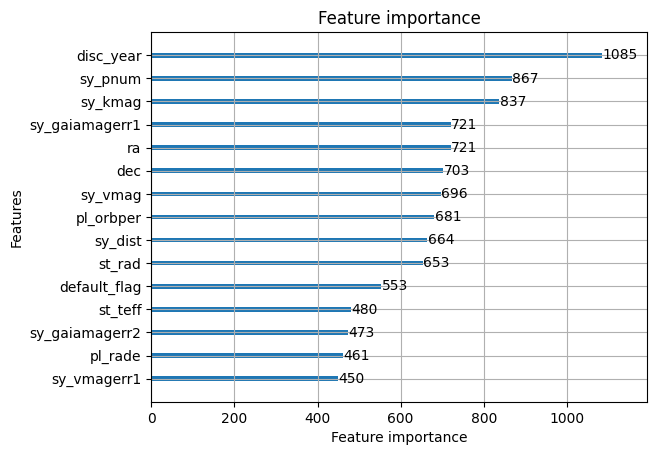

In [19]:
lgb.plot_importance(final_model, max_num_features=15)
